In [1]:
import os
import json
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cf

from scipy.optimize import curve_fit

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import DOWN_raw
from function import ART_preprocessing as ART_pre

In [2]:
product, time_reso = 'CMORPH', '3h'

In [3]:
yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : CMORPH_3h.json
Number of threads: 27
Neighborhood area: 5x5



In [8]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite')

In [9]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    VENETO_DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_1000.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [10]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1, lat_min-1), lon=slice(lon_min-1, lon_max+1))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1, lat_max+1), lon=slice(lon_min-1, lon_max+1))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc


<xarray.Dataset> Size: 47MB
Dimensions:  (time: 32144, lat: 18, lon: 20)
Coordinates:
  * lat      (lat) float32 72B 43.62 43.88 44.12 44.38 ... 47.38 47.62 47.88
  * lon      (lon) float32 80B 9.625 9.875 10.12 10.38 ... 13.88 14.12 14.38
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float32 46MB ...
Attributes:
    description:  CMORPH hourly data for Italy region in 1998 to 2023

In [11]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_mean = ds_veneto.resample(time ='D').sum(dim='time', skipna=False).mean(dim='time', skipna=True)
elif time_reso == '1dy':
    PRE_mean = ds_veneto.mean(dim='time', skipna=True)
else:
    raise SystemExit(f"Time resolution not found: {time_reso}")

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del ds_veneto

PRE_mean

<xarray.Dataset> Size: 568B
Dimensions:  (lat: 10, lon: 12)
Coordinates:
  * lat      (lat) float32 40B 44.62 44.88 45.12 45.38 ... 46.38 46.62 46.88
  * lon      (lon) float32 48B 10.62 10.88 11.12 11.38 ... 12.88 13.12 13.38
Data variables:
    PRE      (lat, lon) float32 480B 1.853 1.702 1.577 ... 1.857 2.041 2.203

In [12]:
lon2d_SR, lat2d_SR = np.meshgrid(lons[ndices_lon], lats[ndices_lat])

In [13]:
lat_c = lats[ndices_lat[5]]
lon_c = lons[ndices_lon[5]]

In [14]:
PRE_daily = PRE_data.resample(time ='D').sum(dim='time', skipna=False)
BOX3 = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 1)
box3_lat = BOX3['lat'].data
box3_lon = BOX3['lon'].data
box3_lon2d, box3_lat2d = np.meshgrid(box3_lon, box3_lat)

mask3 = np.full(lat2d.shape, False, dtype=bool)
for la, lo in itertools.product(box3_lat, box3_lon):
    mask3[(lat2d == la) & (lon2d == lo)] = True

In [15]:
PRE_daily = PRE_data.resample(time ='D').sum(dim='time', skipna=False)
BOX5 = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 2)
box5_lat = BOX5['lat'].data
box5_lon = BOX5['lon'].data
box5_lon2d, box5_lat2d = np.meshgrid(box5_lon, box5_lat)

mask5 = np.full(lat2d.shape, False, dtype=bool)
for la, lo in itertools.product(box5_lat, box5_lon):
    mask5[(lat2d == la) & (lon2d == lo)] = True

In [16]:
PRE_daily = PRE_data.resample(time ='D').sum(dim='time', skipna=False)
BOX7 = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, 3)
box7_lat = BOX7['lat'].data
box7_lon = BOX7['lon'].data
box7_lon2d, box7_lat2d = np.meshgrid(box7_lon, box7_lat)

mask7 = np.full(lat2d.shape, False, dtype=bool)
for la, lo in itertools.product(box7_lat, box7_lon):
    mask7[(lat2d == la) & (lon2d == lo)] = True

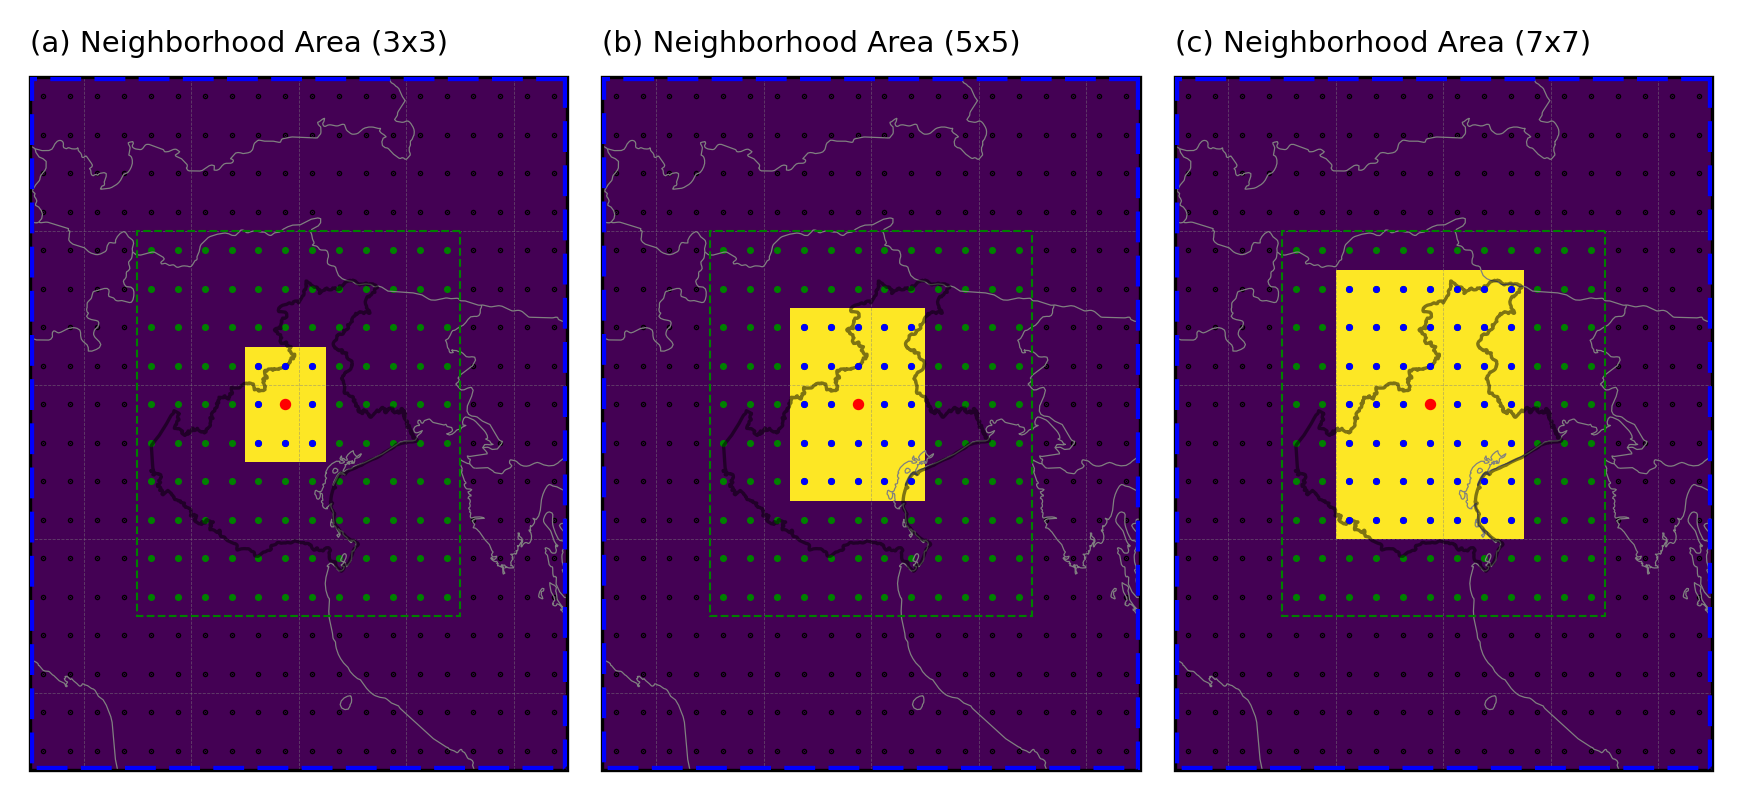

In [17]:
cmap_bin = plt.get_cmap('viridis', 3)  # Use any colormap you like with 2 discrete levels
norm = mcolors.BoundaryNorm([0, 0.5, 1], cmap_bin.N)  

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.pcolormesh(lon2d, lat2d, mask3, cmap=cmap_bin, norm=norm)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='Extended pixels')
ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')

ax1.scatter(box3_lon2d, box3_lat2d, s=0.5, c='b', label='Box pixels', zorder=50)
ax1.scatter(lon_c, lat_c, s=3 , c='r', label='Central pixel', zorder=55)

ax1.plot([],[], color='g',linestyle='--',linewidth=0.5,label='Study region')
ax1.plot([],[], color='b',linestyle='--',linewidth=2,label='Extended region')

ax1.set_title('(a) Neighborhood Area (3x3)', loc='left', fontsize=7)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.pcolormesh(lon2d, lat2d, mask5, cmap=cmap_bin, norm=norm)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='Extended pixels')
ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')

ax1.scatter(box5_lon2d, box5_lat2d, s=0.5, c='b', label='Box pixels', zorder=50)
ax1.scatter(lon_c, lat_c, s=3 , c='r', label='Central pixel', zorder=55)

ax1.plot([],[], color='g',linestyle='--',linewidth=0.5,label='Study region')
ax1.plot([],[], color='b',linestyle='--',linewidth=2,label='Extended region')

ax1.set_title('(b) Neighborhood Area (5x5)', loc='left', fontsize=7)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.pcolormesh(lon2d, lat2d, mask7, cmap=cmap_bin, norm=norm)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='Extended pixels')
ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')

ax1.scatter(box7_lon2d, box7_lat2d, s=0.5, c='b', label='Box pixels', zorder=50)
ax1.scatter(lon_c, lat_c, s=3 , c='r', label='Central pixel', zorder=55)

ax1.plot([],[], color='g',linestyle='--',linewidth=0.5,label='Study region')
ax1.plot([],[], color='b',linestyle='--',linewidth=2,label='Extended region')

ax1.set_title('(c) Neighborhood Area (7x7)', loc='left', fontsize=7)

# ============================================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0, wspace=-0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [18]:
xdata = BOX3.where(BOX3 >= -0.001) # set negative values to np.nan if any
xdaily3 = xdata.resample(time ='24h').sum(dim='time', skipna=False)
xdaily3 = xdaily3.dropna(dim='time', how='any')

rcorr3 = DOWN_raw.grid_corr(xdaily3['PRE'], plot=True, thresh=1, cor_method='pearson')

x3 = np.arange(rcorr3['vdist'].min(),rcorr3['vdist'].max())
MAR3 = DOWN_raw.epl_fun(x3,rcorr3['eps_s'],rcorr3['alp_s'])
STR3 = DOWN_raw.str_exp_fun(x3,rcorr3['d0_s'],rcorr3['mu0_s'])

In [19]:
xdata = BOX5.where(BOX5 >= -0.001) # set negative values to np.nan if any
xdaily5 = xdata.resample(time ='24h').sum(dim='time', skipna=False)
xdaily5 = xdaily5.dropna(dim='time', how='any')

rcorr5 = DOWN_raw.grid_corr(xdaily5['PRE'], plot=True, thresh=1, cor_method='pearson')

x5 = np.arange(rcorr5['vdist'].min(),rcorr5['vdist'].max())
MAR5 = DOWN_raw.epl_fun(x5,rcorr5['eps_s'],rcorr5['alp_s'])
STR5 = DOWN_raw.str_exp_fun(x5,rcorr5['d0_s'],rcorr5['mu0_s'])

In [20]:
xdata = BOX7.where(BOX7 >= -0.001) # set negative values to np.nan if any
xdaily7 = xdata.resample(time ='24h').sum(dim='time', skipna=False)
xdaily7 = xdaily7.dropna(dim='time', how='any')

rcorr7 = DOWN_raw.grid_corr(xdaily7['PRE'], plot=True, thresh=1, cor_method='pearson')

x7 = np.arange(rcorr7['vdist'].min(),rcorr7['vdist'].max())
MAR7 = DOWN_raw.epl_fun(x7,rcorr7['eps_s'],rcorr7['alp_s'])
STR7 = DOWN_raw.str_exp_fun(x7,rcorr7['d0_s'],rcorr7['mu0_s'])

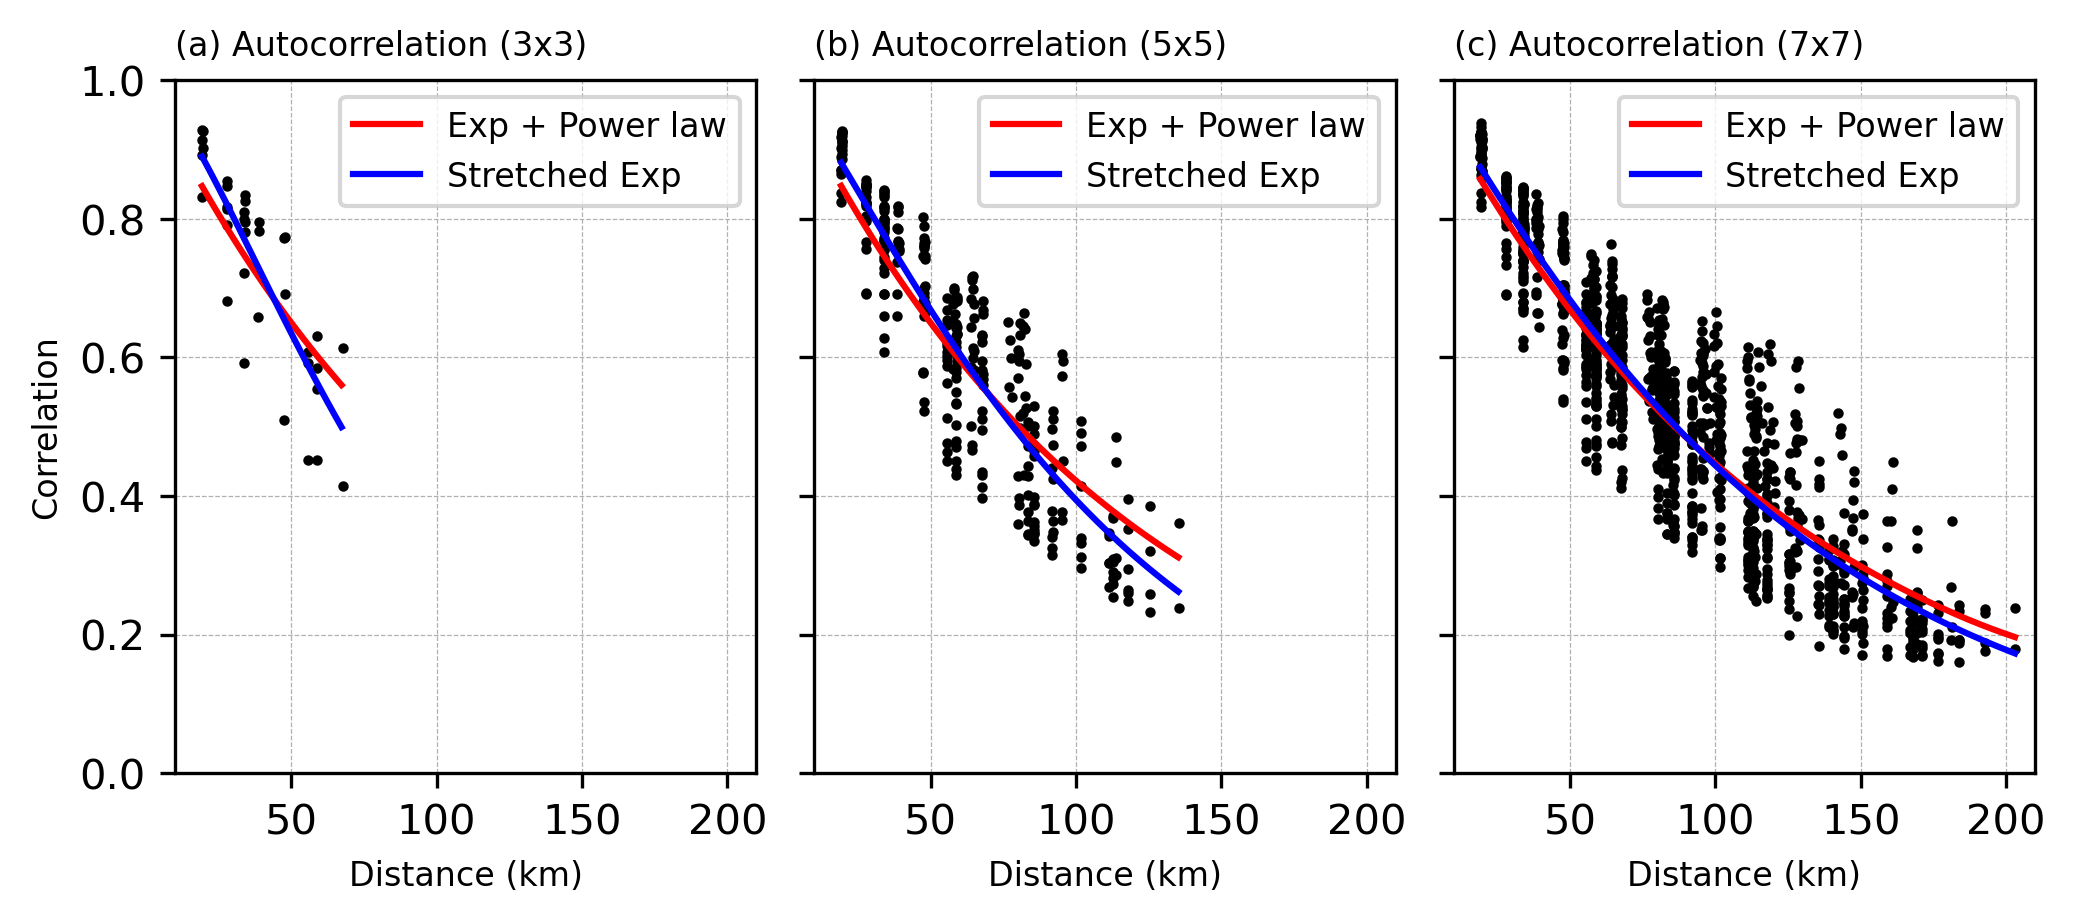

In [21]:
fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(rcorr3['vdist'],rcorr3['vcorr'],'.k',markersize=3)

ax1.plot(x3,MAR3,'-r',label='Exp + Power law')
ax1.plot(x3,STR3,'-b',label='Stretched Exp')

ax1.set_ylim(0,1)
ax1.set_xlim(10,210)
ax1.legend(fontsize=8)
ax1.set_ylabel('Correlation',fontsize=8)
ax1.set_xlabel('Distance (km)',fontsize=8)
ax1.set_title('(a) Autocorrelation (3x3)',loc='left',fontsize=8)
ax1.grid(linewidth=0.3,linestyle='--')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(rcorr5['vdist'],rcorr5['vcorr'],'.k',markersize=3)

ax1.plot(x5,MAR5,'-r',label='Exp + Power law')
ax1.plot(x5,STR5,'-b',label='Stretched Exp')

ax1.set_ylim(0,1)
ax1.set_xlim(10,210)
ax1.legend(fontsize=8)
ax1.set_xlabel('Distance (km)',fontsize=8)
ax1.set_title('(b) Autocorrelation (5x5)',loc='left',fontsize=8)
ax1.set_yticklabels([])
ax1.grid(linewidth=0.3,linestyle='--')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.plot(rcorr7['vdist'],rcorr7['vcorr'],'.k',markersize=3)

ax1.plot(x7,MAR7,'-r',label='Exp + Power law')
ax1.plot(x7,STR7,'-b',label='Stretched Exp')

ax1.set_ylim(0,1)
ax1.set_xlim(10,210)
ax1.legend(fontsize=8)
ax1.set_xlabel('Distance (km)',fontsize=8)
ax1.set_title('(c) Autocorrelation (7x7)',loc='left',fontsize=8)
ax1.set_yticklabels([])
ax1.grid(linewidth=0.3,linestyle='--')

# ============================================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0, wspace=0.1)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

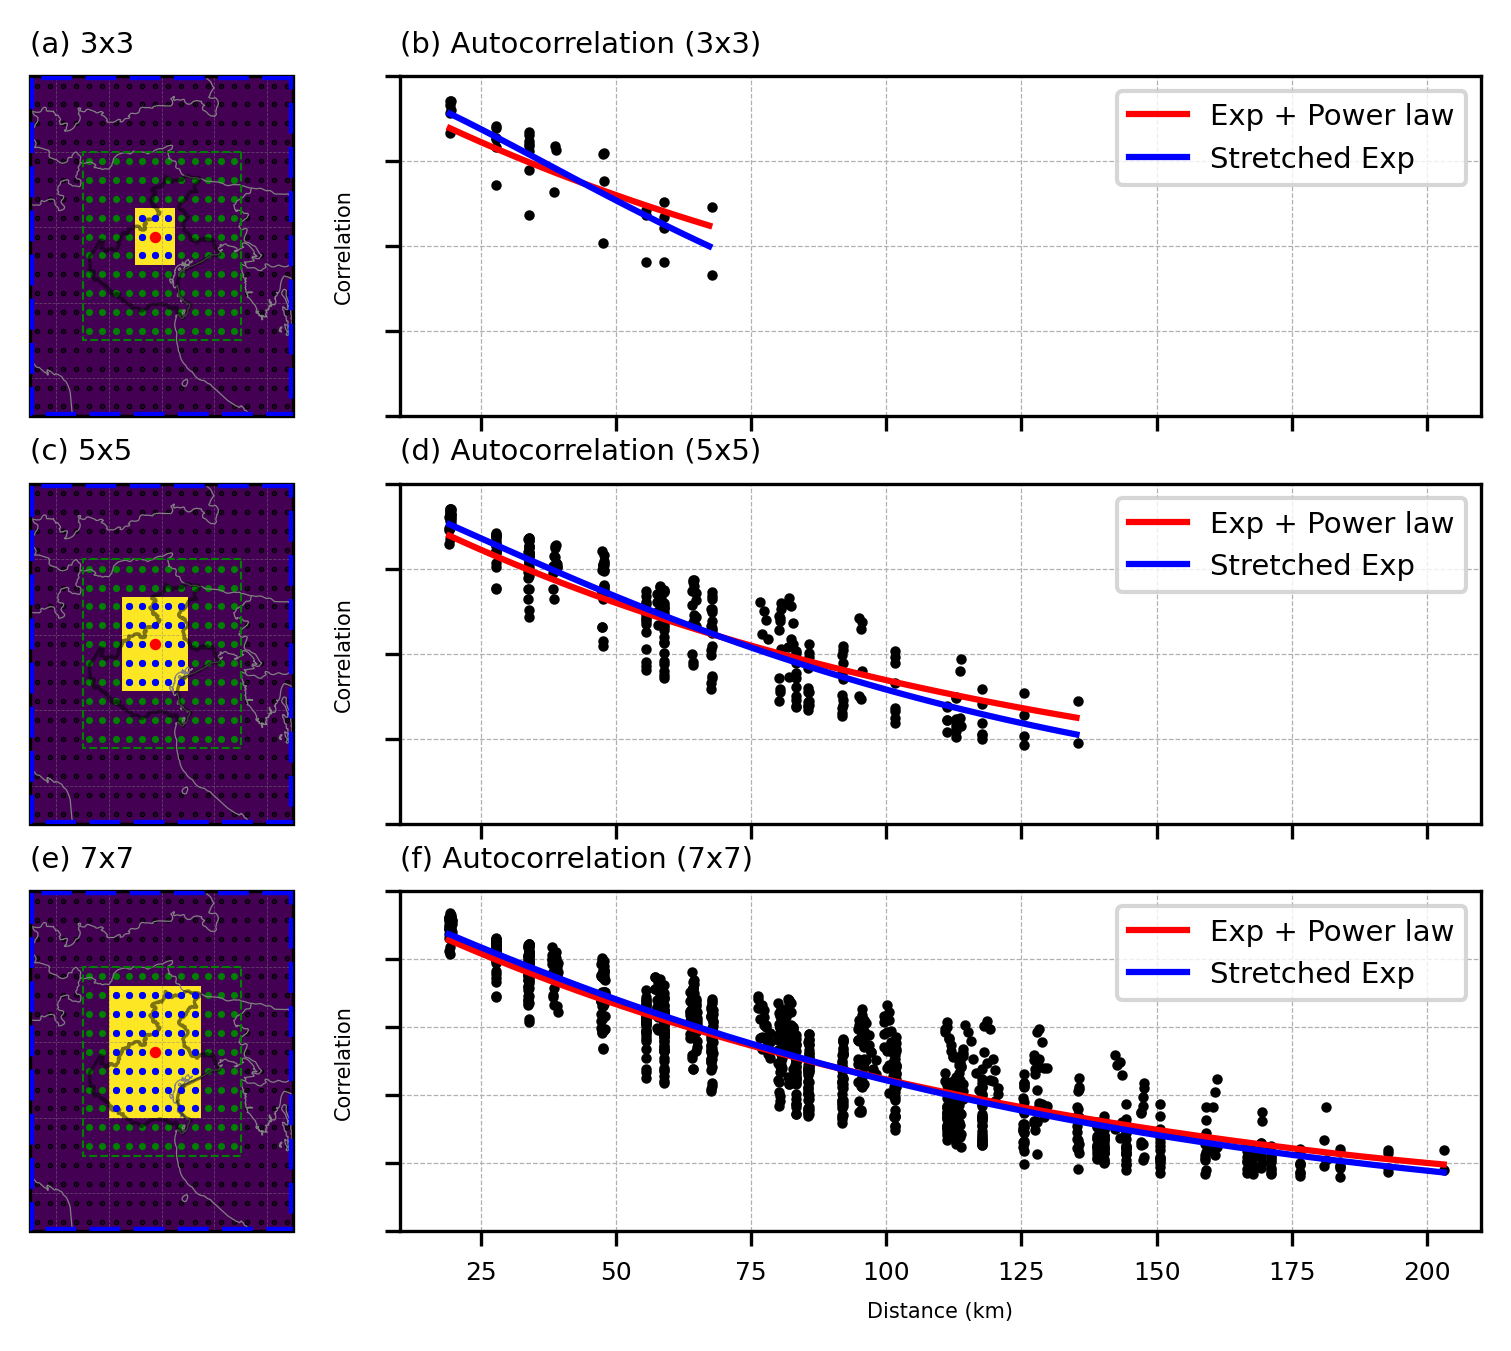

In [22]:
fig = plt.figure(figsize=(8,5),dpi=300)
gs = gridspec.GridSpec(3,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.pcolormesh(lon2d, lat2d, mask3, cmap=cmap_bin, norm=norm)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='Extended pixels')
ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')

ax1.scatter(box3_lon2d, box3_lat2d, s=0.5, c='b', label='Box pixels', zorder=50)
ax1.scatter(lon_c, lat_c, s=3 , c='r', label='Central pixel', zorder=55)

ax1.plot([],[], color='g',linestyle='--',linewidth=0.5,label='Study region')
ax1.plot([],[], color='b',linestyle='--',linewidth=2,label='Extended region')

ax1.set_title('(a) 3x3', loc='left', fontsize=7)


# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.pcolormesh(lon2d, lat2d, mask5, cmap=cmap_bin, norm=norm)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='Extended pixels')
ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')

ax1.scatter(box5_lon2d, box5_lat2d, s=0.5, c='b', label='Box pixels', zorder=50)
ax1.scatter(lon_c, lat_c, s=3 , c='r', label='Central pixel', zorder=55)

ax1.plot([],[], color='g',linestyle='--',linewidth=0.5,label='Study region')
ax1.plot([],[], color='b',linestyle='--',linewidth=2,label='Extended region')

ax1.set_title('(c) 5x5', loc='left', fontsize=7)

# ============================================================================================================================
ax1 = plt.subplot(gs[2, 0], projection = proj)
ax1.set_extent([lon_min-1, lon_max+1, lat_min-1, lat_max+1],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.3,color='grey')
ax1.add_feature(cf.BORDERS,linewidth=0.3,color='grey')
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.8, alpha=0.5)
ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.5,edgecolor='g',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1,lat_max+1),(lon_min-1)-(lon_max+1),(lat_min-1)-(lat_max+1),linestyle='--',linewidth=2,edgecolor='b',facecolor='None',zorder=5))
gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

a1 = ax1.pcolormesh(lon2d, lat2d, mask7, cmap=cmap_bin, norm=norm)

ax1.scatter(lon2d, lat2d, s=0.1, c='k', marker='o', label='Extended pixels')
ax1.scatter(lon2d_SR, lat2d_SR, s=0.5, c='g', marker='o', label='Study pixels')

ax1.scatter(box7_lon2d, box7_lat2d, s=0.5, c='b', label='Box pixels', zorder=50)
ax1.scatter(lon_c, lat_c, s=3 , c='r', label='Central pixel', zorder=55)

ax1.plot([],[], color='g',linestyle='--',linewidth=0.5,label='Study region')
ax1.plot([],[], color='b',linestyle='--',linewidth=2,label='Extended region')

ax1.set_title('(e) 7x7', loc='left', fontsize=7)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.plot(rcorr3['vdist'],rcorr3['vcorr'],'.k',markersize=3)

ax1.plot(x3,MAR3,'-r',label='Exp + Power law')
ax1.plot(x3,STR3,'-b',label='Stretched Exp')

ax1.set_ylim(0,1)
ax1.set_xlim(10,210)
ax1.legend(fontsize=7)
ax1.set_ylabel('Correlation',fontsize=5)
ax1.set_title('(b) Autocorrelation (3x3)',loc='left',fontsize=7)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.grid(linewidth=0.3,linestyle='--')

# =========================================================================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.plot(rcorr5['vdist'],rcorr5['vcorr'],'.k',markersize=3)

ax1.plot(x5,MAR5,'-r',label='Exp + Power law')
ax1.plot(x5,STR5,'-b',label='Stretched Exp')

ax1.set_ylim(0,1)
ax1.set_xlim(10,210)
ax1.legend(fontsize=7)
ax1.set_ylabel('Correlation',fontsize=5)
ax1.set_title('(d) Autocorrelation (5x5)',loc='left',fontsize=7)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.grid(linewidth=0.3,linestyle='--')

# =========================================================================================================================
ax1 = plt.subplot(gs[2, 1])
ax1.plot(rcorr7['vdist'],rcorr7['vcorr'],'.k',markersize=3)

ax1.plot(x7,MAR7,'-r',label='Exp + Power law')
ax1.plot(x7,STR7,'-b',label='Stretched Exp')

ax1.set_ylim(0,1)
ax1.set_xlim(10,210)
ax1.legend(fontsize=7)
ax1.set_ylabel('Correlation',fontsize=5)
ax1.set_xlabel('Distance (km)',fontsize=5)
ax1.set_title('(f) Autocorrelation (7x7)',loc='left',fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_yticklabels([])
ax1.grid(linewidth=0.3,linestyle='--')

# ============================================================================================================================
plt.subplots_adjust(wspace=-0.28, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)